# Where do I move into in Seattle?
by Viyang Shah

## Table of contents
* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction <a name="introduction"></a>

I recently visited Seattle, and I enjoyed my time there. I was researching what it would take to move there, and I came across the idea for my Capstone project.

For people moving to Seattle, how can we find a good neighborhood to move into?

This question can be answered in a myriad of ways, but I am trying to answer it by clustering 12 of the best neighborhoods in Seattle based on the frequency of different venues at their locations.

I will try to find neighborhoods that have a unique list of venues and are affordable compared to other neighborhoods that are considered. Using k-means clustering and increasing the number of clusters, I can find neighborhoods that have similar kinds of venues in the Foursquare database. 

### Project Audience

This project will help people who are deciding to move to Seattle, who will be the target audience. It will help them decide a neighborhood to look for apartments in, at an affordable rate.

### Expected Result

Usually there is wiggle room with respect to the amount of rent a person is willing to pay, so the result of this project is to get a visual representation of the data that helps make an informed choice.

I will start by importing the python modules that I need.

In [1]:
import numpy as np

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json
from geopy.geocoders import Nominatim

from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib.patches as mpatches
from PIL import ImageColor
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans

import folium

import requests
from bs4 import BeautifulSoup

import geocoder
import time

from re import sub
from decimal import Decimal

print('Libraries imported.')

Libraries imported.


## Data<a name="data"></a>

I will be considering 12 neighborhoods, the average rent at these places, and the uniqueness of venues in a 500-meter radius of each neighborhood’s location.

Neighborhood name and the Average Rent in USD will be obtained by web scraping the following website:
https://www.seattlemet.com/home-and-real-estate/2019/03/the-top-12-neighborhoods-in-seattle-2019-edition

Data obtained using the Foursquare API will also be used for the project. Foursquare data will be queried using the API to get a list of venues, and the categories in which those venues lie.

Now, I will web scrape a website to get neighborhood and average rent information. I will also be converting values for average rent in currency format to float type objects.

In [2]:
url = 'https://www.seattlemet.com/home-and-real-estate/2019/03/the-top-12-neighborhoods-in-seattle-2019-edition'
data  = requests.get(url).text
soup = BeautifulSoup(data, 'html5lib')

neighborhoods = []
for neigh in soup.find_all('h3')[1:]:
    if '(' in neigh.get_text():
        neighb = neigh.get_text().split(' (')[0]
    else:
        neighb = neigh.get_text()
    if neighb in ["Seattle's Hottest Neighborhoods by the Numbers", 'Channels', 'About Us', 'Subscriptions', 'Other SagaCity Media']:
        continue
    neighborhoods.append(neighb)

average_rent_usd = []
for each_tag in soup.find_all('blockquote'):
    for data_entry in each_tag.get_text().split('\xa0 •\xa0'):
        if 'Rent' in data_entry:
            average_rent_usd.append(Decimal(sub(r'[^\d.]', '', data_entry.split('$')[1])))

print(neighborhoods)

['West Seattle', 'Beacon Hill', 'Ravenna', 'Columbia City', 'Ballard', 'Interbay', 'South Park', 'Central District', 'Georgetown', 'Lake City', 'Greenwood', 'Capitol Hill']


Now, I will geocode the neighborhood addresses to get their longitude and latitude, which I will store along with other information to a pandas dataframe called 'seattle_neigh'.

In [3]:
locator = Nominatim(user_agent='myGeocoder')

lat = []
lon = []
for address in neighborhoods:
    address = address + ', Seattle, WA'
    location = locator.geocode(address)
    lat.append(location.latitude)
    lon.append(location.longitude)

seattle_neigh = pd.DataFrame()
seattle_neigh['Neighborhood'] = neighborhoods
seattle_neigh['Average Rent (USD)'] = average_rent_usd
seattle_neigh['Latitude'] = lat
seattle_neigh['Longitude'] = lon
seattle_neigh.head()

,Neighborhood,Average Rent (USD),Latitude,Longitude
0,West Seattle,1832,47.570932,-122.386517
1,Beacon Hill,1634,47.579271,-122.311794
2,Ravenna,1598,47.675654,-122.297626
3,Columbia City,2272,47.557912,-122.285216
4,Ballard,2174,47.676507,-122.386223


In [4]:
seattle_neigh.to_csv('neighborhoods-data.csv')

To visualize the locations of these neighborhoods, I will plot them on a map of Seattle using Folium.

In [5]:
address = 'Seattle, WA'

geolocator = Nominatim(user_agent="sea-surfer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
map_seattle = folium.Map(location=[latitude, longitude], zoom_start=11, tiles='CartoDB positron')

for lat, lng, neighborhood in zip(seattle_neigh['Latitude'], seattle_neigh['Longitude'], seattle_neigh['Neighborhood']):
    label = neighborhood
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_seattle)  
    
map_seattle

Now that I have the neighborhoods and their locations, I can search for venues near these locations using the Foursquare API, and I will store the venue name, category, and location to a new pandas dataframe called 'seattle_venues'.

In [6]:
{
    "tags": [
        "remove-cell"
    ]
}

CLIENT_ID = 'MHHLLZOS144U44BZKQTGKNAM4PX2Z10NOKBOK5A2GRCRMKM4'
CLIENT_SECRET = 'FHXGOYHIHHRJDML5YBJX1GYL4OVJTQTW15JFKKT20RPTOREW'
VERSION = '20180605'
radius = 500
LIMIT = 100

In [7]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [8]:
seattle_venues = getNearbyVenues(seattle_neigh['Neighborhood'], seattle_neigh['Latitude'], seattle_neigh['Longitude'])
seattle_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,West Seattle,47.570932,-122.386517,Olympia Coffee,47.569384,-122.386682,Coffee Shop
1,West Seattle,47.570932,-122.386517,Meeples Games,47.570496,-122.387040,Gaming Cafe
2,West Seattle,47.570932,-122.386517,Prost - West Seattle,47.573494,-122.386959,Pub
3,West Seattle,47.570932,-122.386517,West Seattle Runner,47.570363,-122.387090,Sporting Goods Shop
4,West Seattle,47.570932,-122.386517,Spiro's Pizza & Pasta - West Seattle,47.573744,-122.386958,Pizza Place


In [9]:
seattle_venues.to_csv('venues-near-neighborhoods.csv')

## Methodology<a name="methodology"></a>

Now that we have data about the venues in these neighborhoods, we can start with our analysis.

To find neighborhoods that have similar venues, we use a K-means clustering algorithm. Clustering measures the similarity of factors (e.g. venue frequency) to cluster neighborhoods together. Since we are only considering 12 neighborhoods, most neighborhoods that are similar to each other will be clustered together, whereas unique neighborhoods will be a part of their individual clusters.

I will start with sorting the neighborhoods into 3 clusters first, and then I will move on to sorting neighborhoods into 4 clusters to see if any bigger clusters are formed. Sorting these neighborhoods into more clusters overfits the data, as we will see neighborhoods that are similar to be split into different clusters, which we do not want.

After I am done with clustering, I will sort the dataframe along with the cluster labels according to the Average Rent, which I will then display on a bar plot. Hopefully, I will find unique neighborhoods that have apartments at a moderate rent amount.

## Analysis<a name="analysis"></a>

Now, I will go through the analysis part of the project. What I am essentially doing is getting the venue data to make an alternate dataframe that holds information about the weighted frequency at which categories of venues appear for each neighborhood. This new dataframe is called 'seattle_grouped'.

In [10]:
seattle_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Ballard,11,11,11,11,11,11
Beacon Hill,17,17,17,17,17,17
Capitol Hill,58,58,58,58,58,58
Central District,20,20,20,20,20,20
Columbia City,35,35,35,35,35,35
Georgetown,31,31,31,31,31,31
Greenwood,46,46,46,46,46,46
Interbay,11,11,11,11,11,11
Lake City,35,35,35,35,35,35


In [11]:
print('There are {} uniques categories.'.format(len(seattle_venues['Venue Category'].unique())))

There are 130 uniques categories.


In [12]:
# one hot encoding
seattle_onehot = pd.get_dummies(seattle_venues[['Venue Category']], prefix="", prefix_sep="")

#seattle_onehot = seattle_onehot.drop(['Neighborhood'], axis=1)

# add neighborhood column back to dataframe
seattle_onehot['Neighborhood'] = seattle_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [seattle_onehot.columns[-1]] + list(seattle_onehot.columns[:-1])
seattle_onehot = seattle_onehot[fixed_columns]

seattle_onehot.head()

,Neighborhood,ATM,African Restaurant,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bakery,Bank,Bar,Baseball Field,Bed & Breakfast,Beer Bar,Beer Store,Bike Shop,Bookstore,Breakfast Spot,Brewery,Burger Joint,Bus Stop,Café,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Comic Shop,Construction & Landscaping,Convenience Store,Creperie,Dance Studio,Department Store,Design Studio,Diner,Dog Run,Ethiopian Restaurant,Event Space,Farmers Market,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Gas Station,Gastropub,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Hawaiian Restaurant,Herbs & Spices Store,Hobby Shop,Home Service,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kids Store,Korean Restaurant,Library,Liquor Store,Lounge,Marijuana Dispensary,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Music Venue,New American Restaurant,Noodle House,Other Repair Shop,Park,Pawn Shop,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pub,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Salad Place,Salon / Barbershop,Salsa Club,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shipping Store,Shoe Repair,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,West Seattle,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,West Seattle,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,West Seattle,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,West Seattle,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,West Seattle,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
seattle_grouped = seattle_onehot.groupby('Neighborhood').mean().reset_index()
seattle_grouped

,Neighborhood,ATM,African Restaurant,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bakery,Bank,Bar,Baseball Field,Bed & Breakfast,Beer Bar,Beer Store,Bike Shop,Bookstore,Breakfast Spot,Brewery,Burger Joint,Bus Stop,Café,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Comic Shop,Construction & Landscaping,Convenience Store,Creperie,Dance Studio,Department Store,Design Studio,Diner,Dog Run,Ethiopian Restaurant,Event Space,Farmers Market,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Gas Station,Gastropub,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Hawaiian Restaurant,Herbs & Spices Store,Hobby Shop,Home Service,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kids Store,Korean Restaurant,Library,Liquor Store,Lounge,Marijuana Dispensary,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Music Venue,New American Restaurant,Noodle House,Other Repair Shop,Park,Pawn Shop,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pub,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Salad Place,Salon / Barbershop,Salsa Club,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shipping Store,Shoe Repair,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,Ballard,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.090909,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.090909,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.0,0.000000,0.000000,0.000000,0.090909,0.00,0.000000,0.000000,0.000000,0.00,0.090909,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Beacon Hill,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,0.000000,0.000000,0.117647,0.000000,0.000000,0.00,0.000000,0.000000,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,0.00,0.000000,0.000000,0.000000,0.000000,0.058824,0.000000,0.000000,0.117647,0.000000,0.000000,0.000000,0.000000,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.058824,0.000000,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.058824,0.000000,0.00,0.058824,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.058824,0.000000,0.000000,0.000000,0.00

In [14]:
num_top_venues = 5

for hood in seattle_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = seattle_grouped[seattle_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Ballard----
                   venue  freq
0             Playground  0.09
1                    Bar  0.09
2      French Restaurant  0.09
3          Jewelry Store  0.09
4  Sri Lankan Restaurant  0.09


----Beacon Hill----
                      venue  freq
0               Gas Station  0.12
1                      Café  0.12
2  Mediterranean Restaurant  0.06
3               Pizza Place  0.06
4       Filipino Restaurant  0.06


----Capitol Hill----
                venue  freq
0         Coffee Shop  0.09
1  Italian Restaurant  0.07
2     Thai Restaurant  0.07
3        Cocktail Bar  0.07
4  Mexican Restaurant  0.05


----Central District----
                   venue  freq
0            Coffee Shop  0.15
1  Performing Arts Venue  0.10
2   Ethiopian Restaurant  0.05
3              BBQ Joint  0.05
4         Breakfast Spot  0.05


----Columbia City----
                venue  freq
0         Coffee Shop  0.09
1         Pizza Place  0.06
2  African Restaurant  0.06
3                 Bar  0.06
4   

At this step, we can see the unique venues that appear for each neighborhood in the search. We can see that 'Coffee Shop' appears very often for some of these neighborhoods, which is expected for the city of Seattle. We can also see how often other venues appear for each neighborhood in the search.

The next step is to sort the venue categories in the neighborhood to find the most common venues and append them to a new dataframe 'neighborhoods_venues_sorted'.

In [15]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [16]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = seattle_grouped['Neighborhood']

for ind in np.arange(seattle_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(seattle_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ballard,Playground,Jewelry Store,Coffee Shop,Park,Restaurant,Food Truck,Baseball Field,Bar,Sri Lankan Restaurant,French Restaurant
1,Beacon Hill,Gas Station,Café,Yoga Studio,Bakery,Grocery Store,Fried Chicken Joint,Filipino Restaurant,Mediterranean Restaurant,Mexican Restaurant,Pizza Place
2,Capitol Hill,Coffee Shop,Thai Restaurant,Italian Restaurant,Cocktail Bar,Mexican Restaurant,Yoga Studio,Japanese Restaurant,Bar,American Restaurant,Pet Store
3,Central District,Coffee Shop,Performing Arts Venue,Playground,Breakfast Spot,Fish & Chips Shop,Liquor Store,Ethiopian Restaurant,Park,Pizza Place,Plaza
4,Columbia City,Coffee Shop,Ice Cream Shop,African Restaurant,Pizza Place,Bar,Caribbean Restaurant,Indie Movie Theater,Sandwich Place,Juice Bar,Brewery


Now begins the fun. I will be using a K-means clustering algorithm to cluster together neighborhoods that have similar venue types. I will start by making 3 clusters and populating them, and then I will go on to make 4 clusters. The cluster label results results for 4 clusters are saved in the 'seattle_merged' dataframe.

In [17]:
# set number of clusters as 3
kclusters = 3

seattle_grouped_clustering = seattle_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(seattle_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0], dtype=int32)

In [18]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

seattle_merged = seattle_neigh

# merge seattle_grouped with seattle_data to add latitude/longitude for each neighborhood
seattle_merged = seattle_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

seattle_merged.head() # check the last columns!

,Neighborhood,Average Rent (USD),Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,West Seattle,1832,47.570932,-122.386517,0,Pizza Place,Coffee Shop,Gaming Cafe,Park,Pub,Sandwich Place,Sporting Goods Shop,Kids Store,Convenience Store,Gym / Fitness Center
1,Beacon Hill,1634,47.579271,-122.311794,0,Gas Station,Café,Yoga Studio,Bakery,Grocery Store,Fried Chicken Joint,Filipino Restaurant,Mediterranean Restaurant,Mexican Restaurant,Pizza Place
2,Ravenna,1598,47.675654,-122.297626,0,Mediterranean Restaurant,Southern / Soul Food Restaurant,Yoga Studio,Sushi Restaurant,Grocery Store,New American Restaurant,Creperie,Pizza Place,Café,Coffee Shop
3,Columbia City,2272,47.557912,-122.285216,0,Coffee Shop,Ice Cream Shop,African Restaurant,Pizza Place,Bar,Caribbean Restaurant,Indie Movie Theater,Sandwich Place,Juice Bar,Brewery
4,Ballard,2174,47.676507,-122.386223,0,Playground,Jewelry Store,Coffee Shop,Park,Restaurant,Food Truck,Baseball Field,Bar,Sri Lankan Restaurant,French Restaurant


In [19]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11, tiles = 'CartoDB positron')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
seattle_merged = seattle_merged.dropna(axis=0)
for lat, lon, poi, cluster in zip(seattle_merged['Latitude'], seattle_merged['Longitude'], seattle_merged['Neighborhood'], seattle_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [20]:
# set number of clusters as 4
kclusters = 4

seattle_grouped_clustering = seattle_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(seattle_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 3, 0, 2], dtype=int32)

In [21]:
# add clustering labels
neighborhoods_venues_sorted = neighborhoods_venues_sorted.drop('Cluster Labels', 1)
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

seattle_merged = seattle_neigh

# merge seattle_grouped with seattle_data to add latitude/longitude for each neighborhood
seattle_merged = seattle_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

seattle_merged.head() # check the last columns!

,Neighborhood,Average Rent (USD),Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,West Seattle,1832,47.570932,-122.386517,0,Pizza Place,Coffee Shop,Gaming Cafe,Park,Pub,Sandwich Place,Sporting Goods Shop,Kids Store,Convenience Store,Gym / Fitness Center
1,Beacon Hill,1634,47.579271,-122.311794,0,Gas Station,Café,Yoga Studio,Bakery,Grocery Store,Fried Chicken Joint,Filipino Restaurant,Mediterranean Restaurant,Mexican Restaurant,Pizza Place
2,Ravenna,1598,47.675654,-122.297626,2,Mediterranean Restaurant,Southern / Soul Food Restaurant,Yoga Studio,Sushi Restaurant,Grocery Store,New American Restaurant,Creperie,Pizza Place,Café,Coffee Shop
3,Columbia City,2272,47.557912,-122.285216,0,Coffee Shop,Ice Cream Shop,African Restaurant,Pizza Place,Bar,Caribbean Restaurant,Indie Movie Theater,Sandwich Place,Juice Bar,Brewery
4,Ballard,2174,47.676507,-122.386223,0,Playground,Jewelry Store,Coffee Shop,Park,Restaurant,Food Truck,Baseball Field,Bar,Sri Lankan Restaurant,French Restaurant


In [22]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11, tiles = 'CartoDB positron')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
seattle_merged = seattle_merged.dropna(axis=0)
for lat, lon, poi, cluster in zip(seattle_merged['Latitude'], seattle_merged['Longitude'], seattle_merged['Neighborhood'], seattle_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Results and Discussion<a name="results"></a>

As we can see, adding more clusters does not separate the neighborhoods in clusters of multiple sizes, but it singles out unique neighborhoods that have less venues in common with others. Therefore, the neighborhoods that do not fall into the first cluster with label '0' are unique from the others, and have venues that may not be commonly found in other neighborhoods.

Now, I will sort the 'seattle_merged' dataframe by Average Rent, and plot it out along with color coded cluster labels to visualize the findings of this project. The final plot is saved as a file called 'neigh_seattle_results.png'.

In [23]:
# Sorting neighborhoods with respect to their average rent
seattle_merged.sort_values('Average Rent (USD)', inplace=True)
seattle_merged.to_csv('sorted_seattle_neighborhoods.csv')
seattle_merged

,Neighborhood,Average Rent (USD),Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Lake City,1379,47.719162,-122.295494,0,Bar,Bank,Thai Restaurant,Mexican Restaurant,Pizza Place,Home Service,Pawn Shop,Bus Stop,Rental Car Location,Café
5,Interbay,1525,47.640742,-122.376339,3,Golf Course,Coffee Shop,Bus Stop,Grocery Store,Arts & Crafts Store,Wine Shop,Department Store,Ice Cream Shop,Pet Store,Bike Shop
2,Ravenna,1598,47.675654,-122.297626,2,Mediterranean Restaurant,Southern / Soul Food Restaurant,Yoga Studio,Sushi Restaurant,Grocery Store,New American Restaurant,Creperie,Pizza Place,Café,Coffee Shop
1,Beacon Hill,1634,47.579271,-122.311794,0,Gas Station,Café,Yoga Studio,Bakery,Grocery Store,Fried Chicken Joint,Filipino Restaurant,Mediterranean Restaurant,Mexican Restaurant,Pizza Place
8,Georgetown,1800,47.548933,-122.330057,0,Coffee Shop,Bar,Japanese Restaurant,Sandwich Place,ATM,Construction & Landscaping,Salad Place,Rental Car Location,Pub,Clothing Store
10,Greenwood,1820,47.690981,-122.354877,0,Coffee Shop,Spa,Mexican Restaurant,Bookstore,Bar,Pizza Place,Comic Shop,Brewery,Pub,Playground
0,West Seattle,1832,47.570932,-122.386517,0,Pizza Place,Coffee Shop,Gaming Cafe,Park,Pub,Sandwich Place,Sporting Goods Shop,Kids Store,Convenience Store,Gym / Fitness Center
7,Central District,1948,47.603110,-122.308270,0,Coffee Shop,Performing Arts Venue,Playground,Breakfast Spot,Fish & Chips Shop,Liquor Store,Ethiopian Restaurant,Park,Pizza Place,Plaza
11,Capitol Hill,2070,47.623831,-122.318368,0,Coffee Shop,Thai Restaurant,Italian Restaurant,Cocktail Bar,Mexican Restaurant,Yoga Studio,Japanese Restaurant,Bar,American Restaurant,Pet Store
4,Ballard,2174,47.676507,-122.386223,0,Playground,Jewelry Store,Coffee Shop,Park,Restaurant,Food Truck,Baseball Field,Bar,Sri Lankan Restaurant,French Restaurant


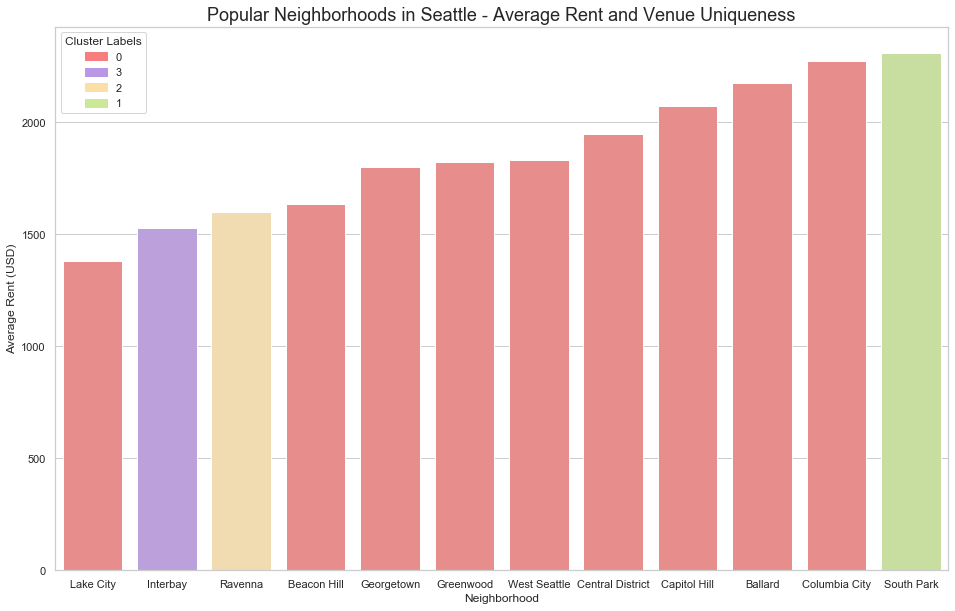

In [24]:
color_list = []
for each_neigh in seattle_merged['Cluster Labels'].iloc:
    if each_neigh == 0:
        color_list.append('#F67E7D')
    elif each_neigh == 1:
        color_list.append('#CBE896')
    elif each_neigh == 2:
        color_list.append('#FCDFA6')
    else:
        color_list.append('#BC96E6')

color_list = [colors.rgb2hex(i) for i in color_list]

sns.set_theme(style="whitegrid")
sns.set_context('notebook')
fig, ax = plt.subplots(figsize=(16,10))
ax = sns.barplot(x="Neighborhood", y="Average Rent (USD)", 
                 data=seattle_merged, palette=color_list)

patches = [mpatches.Patch(color=color_list[i], label=seattle_merged['Cluster Labels'].iloc[i]) for i in range(len(color_list))]
using = []
use_patches = []
for each_label in patches:
    if each_label.get_label() not in using:
        using.append(each_label.get_label())
        use_patches.append(each_label)

plt.title('Popular Neighborhoods in Seattle - Average Rent and Venue Uniqueness', fontsize=18)
plt.legend(handles=use_patches, title='Cluster Labels',loc="upper left")
plt.savefig('neigh_seattle_results.png', dpi=1000)

From the results, we can see that neighborhoods Interbay, Ravenna and South Park have unique venues. Furthermore, we see that the South Park neighborhood has a much higher average rent than other neighborhoods, so its uniqueness has a price.

Interbay and Ravenna both have moderate to low average rent for Seattle. After a brief Google search, I found out that Interbay, as the name says, has a Fisherman's terminal and an extensive railroad network to transport shipped goods to other cities and states. It seems more like an industrial area with some good sites, such as a golf course and bike shops.

If it were my decision, I would choose to move to Ravenna, a unique neighborhood in Seattle with affordable rent and cultural diversity.

## Conclusion<a name="conclusion"></a>

I used a K-means clustering algorithm to single out unique neighborhoods from a list of 12, and I found 3 such neighborhoods by making 4 clusters. Based on rent, I decided that the two neighborhoods I would consider moving into were Interbay and Ravenna. The results are displayed above, so others who would like to use my data to decide can do so.

However, there are a lot more factors that might go into realistically deciding a neighborhood to stay in. For instance, proximity to work, availability of apartments to rent, and access to highways can also be considered in the decision-making process. It all comes down to the individual use case for the information, and results can therefore not be generalized.

The K-means clustering algorithm is helpful, though, and more data might yield a more general result. To make the results more historically accurate, the data used will need to be updated, too.

### How are these results helpful?
Think about it this way. To visit venues that are common to many neighborhoods in Seattle, you can visit one of the many neighborhoods in Seattle. But wouldn't it be nice to stay in a neighborhood with unique places to walk to? This might also result in cultural diversity of the area, depending on the venues.

Ravenna has many Southern / Soul food and Mediterranean restaurants, and it has its fair share of coffee shops too. Cuisine from different places on Earth can signify the diversity of taste, or simply the ethnicity of the population living there. Either way, this tells us more about these places in a faraway city, and the venues that make it special.